In [ ]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# custom dataset class for albumentations library
  class AlbumentationImageDataset(Dataset):
    def __init__(self, image_list):
        self.image_list = image_list
        self.aug = A.Compose({
        A.Resize(200, 300),
        A.CenterCrop(100, 100),
        A.RandomCrop(80, 80),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=(-90, 90)),
        A.VerticalFlip(p=0.5),
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        })
         
    def __len__(self):
        return (len(self.image_list))
    
    def __getitem__(self, i):
        image = plt.imread(self.image_list[i])
        image = Image.fromarray(image).convert('RGB')
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
            
        return torch.tensor(image, dtype=torch.float)

In [ ]:
# The following code initializes the dataset class and prepares the data loader.
alb_dataset = AlbumentationImageDataset(image_list=image_list)
alb_dataloader = DataLoader(dataset=alb_dataset, batch_size=16, shuffle=True)


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

SEED = 1


# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Batch_size = 64
if cuda:
  Batch_size = 128
  

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=Batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=Batch_size)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

alb_trainset_dataset = AlbumentationImageDataset(image_list=trainset)

trainloader = torch.utils.data.DataLoader(alb_trainset_dataset, **dataloader_args)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
alb_testset_dataset = AlbumentationImageDataset(image_list=testset)

                                       download=True)
testloader = torch.utils.data.DataLoader(alb_testset_dataset, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


Let us show some of the training images, for fun.



In [ ]:
len(trainset)

50000

In [ ]:
50000/128

390.625

In [ ]:
type(trainset.data)

numpy.ndarray

In [ ]:
len(testset)

10000

In [ ]:
print(np.min(trainset.data))
print("mean ",np.mean(trainset.data))

0
mean  120.70756512369792


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(3, 546, 274) (546, 274, 3)
 ship  bird   cat   dog


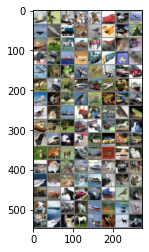

In [ ]:


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape,(np.transpose(npimg, (1, 2, 0))).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
                                                              #RF = rin+(k-1)*jin
                                                              #jout = jin*s
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False), #Rf = 3, j = 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.15),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), #Rf = 3, j = 1
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.15),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),#Rf = 5, , j = 1
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.15),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), #Rf = , j = 1
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(p=0.15),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False), #Rf = 9, , j = 1
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(p=0.15),
            
            )
        self.convblock2 = nn.Sequential(
           nn.Conv2d(in_channels=256, out_channels=64, kernel_size=(3, 3), padding=1,dilation=2, bias=False), #jin=jout=2, kernel_size = 5, rf = 10+(4)*2 = 18
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.15),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1,dilation=2, bias=False), #jin=jout=2, kernel_size = 5, rf = 18+(2)*2 = 22
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(p=0.15),

            
            )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(3, 3), padding=1, bias=False), #jin = jout = 4, rf = 32+(2)*4 = 40
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.15),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1,groups=16, bias=False), #jin = jout = 4, rf = 40+(2)*4 = 48
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.15),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1,groups=32, bias=False),#jin = jout = 4, rf = 48+(2)*4 = 56
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.15),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1,groups=64, bias=False), #jin = jout = 4, rf = 56+(2)*4 = 64
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(p=0.15),
            
            )
        self.convblock4 = nn.Sequential(
          nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(3, 3), padding=1, bias=False), #jin = jout = 8, rf = 68+(2)*8 = 84
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.15),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), #jin = jout = 8, rf = 84+(2)*8 = 100
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.15),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False), #jin = jout = 8, rf = 100+(2)*8 = 116
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.15),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), #jin = jout = 8, rf = 116+(2)*8 = 132
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(p=0.15), # i/p= 28 o/p=26 r=3

            nn.AdaptiveAvgPool2d(1),



            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)#Op_size = 1, 
            

            
            )

        self.pool = nn.MaxPool2d(2, 2)

        self.gap = nn.AdaptiveAvgPool2d(4)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(1, 256)

    def forward(self, x):

        x = self.convblock1(x) # i/p= 32 o/p=32 Rf = 9
        x = self.pool(x) # jin = 1, Rf = 10 j out= 2
        x = self.convblock2(x) # Rf = 30 jout = 2, 
        x = self.pool(x) # jout = 4, s =2, Rf = 30+1*2 = 32
        x = self.convblock3(x) # jin = 4, s = 2 , jout = 8, Rf = 64+1*4 = 68
        x = self.pool(x) # 4
        x = self.convblock4(x)  # 4
     
        x = x.view(-1, 10)
      
        return x


# net = Net()

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = Net().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,432
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
             ReLU-14          [-1,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
minibatches = int(len(trainset)/Batch_size)
minibatches


390

In [ ]:
for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    processed = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs,labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels) # CrossEntropyLoss
        loss.backward()
        optimizer.step() # SGD

        # print statistics
        running_loss += loss.item()

        pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        processed += len(inputs)

        if i == minibatches:    # print every  mini-batches
            print('[%d, %5d] loss: %.3f Acc: %.3f' %(epoch + 1, i + 1, running_loss / 2000,100*correct/processed ))
            running_loss = 0.0


            outputs = net(images.to(device))
            _, predicted = torch.max(outputs, 1)

            #print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]for j in range(4)))
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %.3f %%' % (
                100 * correct / total))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1,   391] loss: 0.367 Acc: 29.176
Accuracy of the network on the 10000 test images: 39.130 %
[2,   391] loss: 0.290 Acc: 44.934
Accuracy of the network on the 10000 test images: 51.070 %
[3,   391] loss: 0.248 Acc: 54.028
Accuracy of the network on the 10000 test images: 56.090 %
[4,   391] loss: 0.220 Acc: 59.744
Accuracy of the network on the 10000 test images: 60.930 %
[5,   391] loss: 0.200 Acc: 63.390
Accuracy of the network on the 10000 test images: 64.350 %
[6,   391] loss: 0.185 Acc: 66.082
Accuracy of the network on the 10000 test images: 66.210 %
[7,   391] loss: 0.174 Acc: 68.702
Accuracy of the network on the 10000 test images: 68.660 %
[8,   391] loss: 0.162 Acc: 70.698
Accuracy of the network on the 10000 test images: 69.610 %
[9,   391] loss: 0.153 Acc: 72.748
Accuracy of the network on the 10000 test images: 71.970 %
[10,   391] loss: 0.146 Acc: 73.984
Accuracy of the network on the 10000 test images: 73.220 %
[11,   391] loss: 0.140 Acc: 75.368
Accuracy of the network

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [ ]:
for epoch in range(40,50):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    processed = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs,labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels) # CrossEntropyLoss
        loss.backward()
        optimizer.step() # SGD

        # print statistics
        running_loss += loss.item()

        pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        processed += len(inputs)

        if i == minibatches:    # print every  mini-batches
            print('[%d, %5d] loss: %.3f Acc: %.3f' %(epoch + 1, i + 1, running_loss / 2000,100*correct/processed ))
            running_loss = 0.0


            outputs = net(images.to(device))
            _, predicted = torch.max(outputs, 1)

            #print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]for j in range(4)))
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %.3f %%' % (
                100 * correct / total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[41,   391] loss: 0.060 Acc: 89.508
Accuracy of the network on the 10000 test images: 81.470 %
[42,   391] loss: 0.059 Acc: 89.664
Accuracy of the network on the 10000 test images: 81.520 %


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:

outputs = net(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.3f %%' % (
    100 * correct / total))

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))